# Feature Engeneering..: Testando Lags e Windows

In [1]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time
from tqdm import tqdm
from IPython.display import display

# --- 1. Carregamento dos Dados ---
print("Carregando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)
print("DataFrame carregado com sucesso.")

# --- 2. Função de Engenharia de Features (VERSÃO CORRIGIDA E SEGURA) ---
def create_safe_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    """
    Cria features de séries temporais garantindo que não haja data leakage.
    """
    df_features = df.copy()
    
    # Lags (já são seguros)
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
        
    # Features de Janela Deslizante (COM A CORREÇÃO .shift(1))
    for window in window_sizes_list:
        # #############################################################################
        # CORREÇÃO CRÍTICA APLICADA AQUI
        # O .shift(1) garante que a janela de cálculo termina em t-1 para prever t.
        # #############################################################################
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean().shift(1)
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std().shift(1)
        
    return df_features

# --- 3. Configurações para o Grid Search ---
l_options = [
    [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72],
    [1, 2, 3, 4, 5, 6, 68, 69, 70, 71, 72],
    [1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]
]

l_windows_options = [
    [12, 24, 72],
    [6, 12, 72],
    [5, 12, 24]
]

models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42, verbose=-1),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- 4. Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("\n--- Iniciando Grid Search Corrigido para Features e Modelos ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features (usando a função segura)
        df_featured = create_safe_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            if model_name == 'LightGBM':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else:
                model.fit(X_train, y_train)
            
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- 5. Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search Corrigido ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

Carregando os dados...
DataFrame carregado com sucesso.

--- Iniciando Grid Search Corrigido para Features e Modelos ---

[Iteração 1/9] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [12, 24, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0611
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.1083
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0612
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0766

[Iteração 2/9] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [6, 12, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0533
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.0992
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0607
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0853

[Iteração 3/9] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [5, 12, 24]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0587
  -> Tr

,model,lags,windows,MAE
0,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[6, 12, 72]",0.053345
1,LightGBM,"[1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]","[6, 12, 72]",0.054241
2,LightGBM,"[1, 2, 3, 4, 5, 6, 68, 69, 70, 71, 72]","[6, 12, 72]",0.057581
3,LightGBM,"[1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]","[5, 12, 24]",0.058662
4,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[5, 12, 24]",0.058708
5,RandomForest,"[1, 2, 3, 4, 5, 6, 68, 69, 70, 71, 72]","[6, 12, 72]",0.058960
6,RandomForest,"[1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]","[12, 24, 72]",0.059735
7,RandomForest,"[1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]","[6, 12, 72]",0.059839
8,LightGBM,"[1, 2, 3, 4, 5, 6, 68, 69, 70, 71, 72]","[12, 24, 72]",0.059856
9,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[6, 12, 72]",0.060659



--- Melhor Combinação Geral Encontrada ---


model                                      LightGBM
lags       [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]
windows                                 [6, 12, 72]
MAE                                        0.053345
Name: 0, dtype: object

In [4]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# --- Assumimos que o DataFrame 'df' já foi carregado ---

# --- Sua Função de Engenharia de Features (sem alterações) ---
def create_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    df_features = df.copy()
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean().shift(1)
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std().shift(1)
    return df_features

# --- Novas Listas de Parâmetros para o Grid Search Fino ---
# Estas listas foram criadas com base nos resultados da primeira busca
# para explorar com mais detalhes as combinações de features mais promissoras.

# --- Novas Listas de Parâmetros para o Grid Search de Alta Precisão ---
# Baseado nos resultados da busca corrigida para encontrar o "ótimo dos ótimos".

l_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72],
    
    # 2. Variação "Menos é Mais?" (Apenas os pontos chave da campeã)
    [1, 2, 3, 6, 8, 36, 72],
    
    # 3. Variação com Foco Sazonal Intenso (mais detalhes perto dos pontos de 12h e 24h)
    [1, 2, 3, 4, 35, 36, 37, 71, 72, 73],
    
    # 4. Variação com Memória de Curto Prazo Estendida (até 4 horas)
    list(range(1, 13)) + [36, 72],
    
    # 5. Variação com Lags Exponenciais (espaçamento crescente)
    [1, 2, 4, 8, 16, 36, 72]
]

l_windows_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [6, 12, 72],
    
    # 2. Variação com a "Ponte" de 12h (adiciona a janela de 36)
    [6, 12, 36, 72],
    
    # 3. Variação com Foco em Janelas Curtas/Médias
    [5, 10, 20, 40],
    
    # 4. Variação "Simples e Eficaz" (apenas a janela curta e a de 24h)
    [6, 72],
    
    # 5. Variação Equilibrada (curta, média-curta, média-longa)
    [4, 12, 36]
]

print("Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.")

# --- Dicionário de Modelos para Testar ---
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("--- Iniciando Grid Search Abrangente para Features e Modelos ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features
        df_featured = create_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            # Lógica de treinamento específica para cada modelo
            if model_name in ['LightGBM']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else: # RandomForest e DecisionTree
                model.fit(X_train, y_train)
            
            # 4. Avaliar e Guardar Resultados
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search Abrangente ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.
--- Iniciando Grid Search Abrangente para Features e Modelos ---

[Iteração 1/25] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [6, 12, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0533
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.0992
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0607
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0853

[Iteração 2/25] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [6, 12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0563
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.1061
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0594
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0816

[Iteração 3/25] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [5, 10, 20, 40]
  -> Treinando LightGBM...
     Resultado MAE 

,model,lags,windows,MAE
0,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.053068
1,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[6, 12, 72]",0.053345
2,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 36, 72]","[6, 12, 72]",0.054751
3,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[6, 72]",0.054799
4,LightGBM,"[1, 2, 4, 8, 16, 36, 72]","[6, 12, 36, 72]",0.054908
...,...,...,...,...
95,DecisionTree,"[1, 2, 3, 6, 8, 36, 72]","[6, 72]",0.120854
96,DecisionTree,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[4, 12, 36]",0.122874
97,DecisionTree,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 36, 72]","[5, 10, 20, 40]",0.148145
98,DecisionTree,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 36, 72]","[6, 12, 36, 72]",0.151183



--- Melhor Combinação Geral Encontrada ---


model                                  LightGBM
lags       [1, 2, 3, 4, 35, 36, 37, 71, 72, 73]
windows                         [6, 12, 36, 72]
MAE                                    0.053068
Name: 0, dtype: object

In [5]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# --- Assumimos que o DataFrame 'df' já foi carregado ---

# --- Sua Função de Engenharia de Features (sem alterações) ---
def create_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    df_features = df.copy()
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean().shift(1)
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std().shift(1)
    return df_features

# --- Novas Listas de Parâmetros para o Grid Search Fino ---
# Estas listas foram criadas com base nos resultados da primeira busca
# para explorar com mais detalhes as combinações de features mais promissoras.

# --- Novas Listas de Parâmetros para o Grid Search de Alta Precisão ---
# Baseado nos resultados da busca corrigida para encontrar o "ótimo dos ótimos".

l_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [1, 2, 3, 4, 35, 36, 37, 71, 72, 73],
    [1,2,3,4,7,8,24,36,72],
    [2,4,6,8,12,24,36,48,72]
]

l_windows_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [6, 12, 36, 72],
    [2, 5, 36, 72],
    [72],
    [4,72],
    [2,4,12, 72],
    
]

print("Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.")

# --- Dicionário de Modelos para Testar ---
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("--- Iniciando Grid Search Abrangente para Features e Modelos ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features
        df_featured = create_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            # Lógica de treinamento específica para cada modelo
            if model_name in ['LightGBM']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else: # RandomForest e DecisionTree
                model.fit(X_train, y_train)
            
            # 4. Avaliar e Guardar Resultados
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search Abrangente ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.
--- Iniciando Grid Search Abrangente para Features e Modelos ---

[Iteração 1/15] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [6, 12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0531
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.0974
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0581
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0835

[Iteração 2/15] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [2, 5, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0608
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.1066
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0596
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0976

[Iteração 3/15] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0555
 

,model,lags,windows,MAE
0,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.053068
1,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 4, 12, 72]",0.054450
2,LightGBM,"[1, 2, 3, 4, 7, 8, 24, 36, 72]",[72],0.055375
3,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]",[72],0.055453
4,LightGBM,"[1, 2, 3, 4, 7, 8, 24, 36, 72]","[6, 12, 36, 72]",0.056980
5,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.058143
6,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 4, 12, 72]",0.058517
7,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 5, 36, 72]",0.059633
8,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]",[72],0.060163
9,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[4, 72]",0.060558



--- Melhor Combinação Geral Encontrada ---


model                                  LightGBM
lags       [1, 2, 3, 4, 35, 36, 37, 71, 72, 73]
windows                         [6, 12, 36, 72]
MAE                                    0.053068
Name: 0, dtype: object

In [6]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# --- Assumimos que o DataFrame 'df' já foi carregado ---

# --- Sua Função de Engenharia de Features (sem alterações) ---
def create_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    df_features = df.copy()
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean().shift(1)
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std().shift(1)
    return df_features

# --- Novas Listas de Parâmetros para o Grid Search Fino ---
# Estas listas foram criadas com base nos resultados da primeira busca
# para explorar com mais detalhes as combinações de features mais promissoras.

# --- Novas Listas de Parâmetros para o Grid Search de Alta Precisão ---
# Baseado nos resultados da busca corrigida para encontrar o "ótimo dos ótimos".

l_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [1, 2, 3, 4, 35, 36, 37, 71, 72, 73],
    [1, 2, 3, 4, 7, 8, 35, 36, 71, 72],
    [1,2,3,4,5,6,7,8,9,10,12,16,18,20,24,36,48,72]
]

l_windows_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [6, 12, 36, 72],
    [2,6,12,24,36,48,72],
    [2,4,6,12,48,72],
    [4,72],
    [2,4,12, 72],
    
]

print("Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.")

# --- Dicionário de Modelos para Testar ---
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("--- Iniciando Grid Search Abrangente para Features e Modelos ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features
        df_featured = create_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            # Lógica de treinamento específica para cada modelo
            if model_name in ['LightGBM']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else: # RandomForest e DecisionTree
                model.fit(X_train, y_train)
            
            # 4. Avaliar e Guardar Resultados
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search Abrangente ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.
--- Iniciando Grid Search Abrangente para Features e Modelos ---

[Iteração 1/15] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [6, 12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0531
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.0974
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0581
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0835

[Iteração 2/15] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [2, 6, 12, 24, 36, 48, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0540
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.1022
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0567
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0755

[Iteração 3/15] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [2, 4, 6, 12, 48, 72]
  -> Treinando LightGBM...
     Resul

,model,lags,windows,MAE
0,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.053068
1,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 18, 20...","[2, 6, 12, 24, 36, 48, 72]",0.053671
2,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 6, 12, 24, 36, 48, 72]",0.053987
3,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 4, 6, 12, 48, 72]",0.054330
4,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 4, 12, 72]",0.054450
5,LightGBM,"[1, 2, 3, 4, 7, 8, 35, 36, 71, 72]","[6, 12, 36, 72]",0.055392
6,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 18, 20...","[2, 4, 6, 12, 48, 72]",0.055634
7,LightGBM,"[1, 2, 3, 4, 7, 8, 35, 36, 71, 72]","[2, 6, 12, 24, 36, 48, 72]",0.055665
8,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 6, 12, 24, 36, 48, 72]",0.056710
9,LightGBM,"[1, 2, 3, 4, 7, 8, 35, 36, 71, 72]","[2, 4, 6, 12, 48, 72]",0.057293



--- Melhor Combinação Geral Encontrada ---


model                                  LightGBM
lags       [1, 2, 3, 4, 35, 36, 37, 71, 72, 73]
windows                         [6, 12, 36, 72]
MAE                                    0.053068
Name: 0, dtype: object

In [7]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# --- Assumimos que o DataFrame 'df' já foi carregado ---

# --- Sua Função de Engenharia de Features (sem alterações) ---
def create_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    df_features = df.copy()
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean().shift(1)
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std().shift(1)
    return df_features

# --- Novas Listas de Parâmetros para o Grid Search Fino ---
# Estas listas foram criadas com base nos resultados da primeira busca
# para explorar com mais detalhes as combinações de features mais promissoras.

# --- Novas Listas de Parâmetros para o Grid Search de Alta Precisão ---
# Baseado nos resultados da busca corrigida para encontrar o "ótimo dos ótimos".

l_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [1, 2, 3, 4, 35, 36, 37, 71, 72, 73],
    [1, 2, 3, 4,     36,         72    ],
    [1, 2,    4,                 72    ]
]

l_windows_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [6, 12, 36, 72],
    [2,6,12,36, 72],
    [12,    36, 72],
    [12,        72],
    [6,         72],
    
]

print("Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.")

# --- Dicionário de Modelos para Testar ---
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("--- Iniciando Grid Search Abrangente para Features e Modelos ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features
        df_featured = create_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            # Lógica de treinamento específica para cada modelo
            if model_name in ['LightGBM']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else: # RandomForest e DecisionTree
                model.fit(X_train, y_train)
            
            # 4. Avaliar e Guardar Resultados
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search Abrangente ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.
--- Iniciando Grid Search Abrangente para Features e Modelos ---

[Iteração 1/15] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [6, 12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0531
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.0974
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0581
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0835

[Iteração 2/15] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [2, 6, 12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0564
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.1004
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0586
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0914

[Iteração 3/15] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGB

,model,lags,windows,MAE
0,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.053068
1,LightGBM,"[1, 2, 4, 72]","[12, 36, 72]",0.053762
2,LightGBM,"[1, 2, 3, 4, 36, 72]","[2, 6, 12, 36, 72]",0.054749
3,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 6, 12, 36, 72]",0.056405
4,LightGBM,"[1, 2, 4, 72]","[12, 72]",0.057214
5,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 72]",0.057700
6,LightGBM,"[1, 2, 4, 72]","[2, 6, 12, 36, 72]",0.057732
7,LightGBM,"[1, 2, 4, 72]","[6, 12, 36, 72]",0.057956
8,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.058143
9,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 6, 12, 36, 72]",0.058573



--- Melhor Combinação Geral Encontrada ---


model                                  LightGBM
lags       [1, 2, 3, 4, 35, 36, 37, 71, 72, 73]
windows                         [6, 12, 36, 72]
MAE                                    0.053068
Name: 0, dtype: object

In [8]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# --- Assumimos que o DataFrame 'df' já foi carregado ---

# --- Sua Função de Engenharia de Features (sem alterações) ---
def create_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    df_features = df.copy()
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean().shift(1)
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std().shift(1)
    return df_features

# --- Novas Listas de Parâmetros para o Grid Search Fino ---
# Estas listas foram criadas com base nos resultados da primeira busca
# para explorar com mais detalhes as combinações de features mais promissoras.

# --- Novas Listas de Parâmetros para o Grid Search de Alta Precisão ---
# Baseado nos resultados da busca corrigida para encontrar o "ótimo dos ótimos".

l_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [1, 2, 3, 4, 35, 36, 37, 71, 72, 73],
    [   2,    4,                 72    ],
    [1, 2,    4,                 72    ]
]

l_windows_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [6, 12, 36, 72],
    [   12, 36, 72],
    [6, 12,     72],
    [2,6, 12,   72]
    
]

print("Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.")

# --- Dicionário de Modelos para Testar ---
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("--- Iniciando Grid Search Abrangente para Features e Modelos ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features
        df_featured = create_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            # Lógica de treinamento específica para cada modelo
            if model_name in ['LightGBM']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else: # RandomForest e DecisionTree
                model.fit(X_train, y_train)
            
            # 4. Avaliar e Guardar Resultados
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search Abrangente ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.
--- Iniciando Grid Search Abrangente para Features e Modelos ---

[Iteração 1/12] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [6, 12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0531
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.0974
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0581
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0835

[Iteração 2/12] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0619
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.1080
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0599
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0726

[Iteração 3/12] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [6, 12, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0

,model,lags,windows,MAE
0,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.053068
1,LightGBM,"[1, 2, 4, 72]","[12, 36, 72]",0.053762
2,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 6, 12, 72]",0.056898
3,LightGBM,"[1, 2, 4, 72]","[6, 12, 36, 72]",0.057956
4,LightGBM,"[1, 2, 4, 72]","[2, 6, 12, 72]",0.058138
5,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.058143
6,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 72]",0.059056
7,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 6, 12, 72]",0.059206
8,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 72]",0.059255
9,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[12, 36, 72]",0.059903



--- Melhor Combinação Geral Encontrada ---


model                                  LightGBM
lags       [1, 2, 3, 4, 35, 36, 37, 71, 72, 73]
windows                         [6, 12, 36, 72]
MAE                                    0.053068
Name: 0, dtype: object

In [11]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# --- Assumimos que o DataFrame 'df' já foi carregado ---

# --- Sua Função de Engenharia de Features (sem alterações) ---
def create_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    df_features = df.copy()
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean().shift(1)
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std().shift(1)
    return df_features

# --- Novas Listas de Parâmetros para o Grid Search Fino ---
# Estas listas foram criadas com base nos resultados da primeira busca
# para explorar com mais detalhes as combinações de features mais promissoras.

# --- Novas Listas de Parâmetros para o Grid Search de Alta Precisão ---
# Baseado nos resultados da busca corrigida para encontrar o "ótimo dos ótimos".

l_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [1, 2, 3, 4, 35, 36, 37, 71, 72, 73],
    [1, 2, 4, 72],
    [1, 2, 4]
]

l_windows_options = [
    # 1. A Campeã (Nosso novo benchmark)
    [6, 12, 36, 72],
    [12,36,72],
    [2,3,4,12, 72]
    
]

print("Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.")

# --- Dicionário de Modelos para Testar ---
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("--- Iniciando Grid Search Abrangente para Features e Modelos ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features
        df_featured = create_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            # Lógica de treinamento específica para cada modelo
            if model_name in ['LightGBM']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else: # RandomForest e DecisionTree
                model.fit(X_train, y_train)
            
            # 4. Avaliar e Guardar Resultados
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search Abrangente ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.
--- Iniciando Grid Search Abrangente para Features e Modelos ---

[Iteração 1/9] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [6, 12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0531
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.0974
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0581
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0835

[Iteração 2/9] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [12, 36, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 0.0619
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.1080
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0599
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0726

[Iteração 3/9] Lags: [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] | Janelas: [2, 3, 4, 12, 72]
  -> Treinando LightGBM...
     Resultado MAE (LightGBM): 

,model,lags,windows,MAE
0,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.053068
1,LightGBM,"[1, 2, 4, 72]","[12, 36, 72]",0.053762
2,LightGBM,"[1, 2, 4]","[12, 36, 72]",0.053920
3,LightGBM,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 3, 4, 12, 72]",0.055767
4,LightGBM,"[1, 2, 4, 72]","[2, 3, 4, 12, 72]",0.056443
5,LightGBM,"[1, 2, 4]","[6, 12, 36, 72]",0.057167
6,LightGBM,"[1, 2, 4, 72]","[6, 12, 36, 72]",0.057956
7,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.058143
8,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[2, 3, 4, 12, 72]",0.059720
9,RandomForest,"[1, 2, 3, 4, 35, 36, 37, 71, 72, 73]","[12, 36, 72]",0.059903



--- Melhor Combinação Geral Encontrada ---


model                                  LightGBM
lags       [1, 2, 3, 4, 35, 36, 37, 71, 72, 73]
windows                         [6, 12, 36, 72]
MAE                                    0.053068
Name: 0, dtype: object

Carregando e preparando os dados...
Criando o DataFrame com as features parcimoniosas...
Calculando a matriz de correlação...


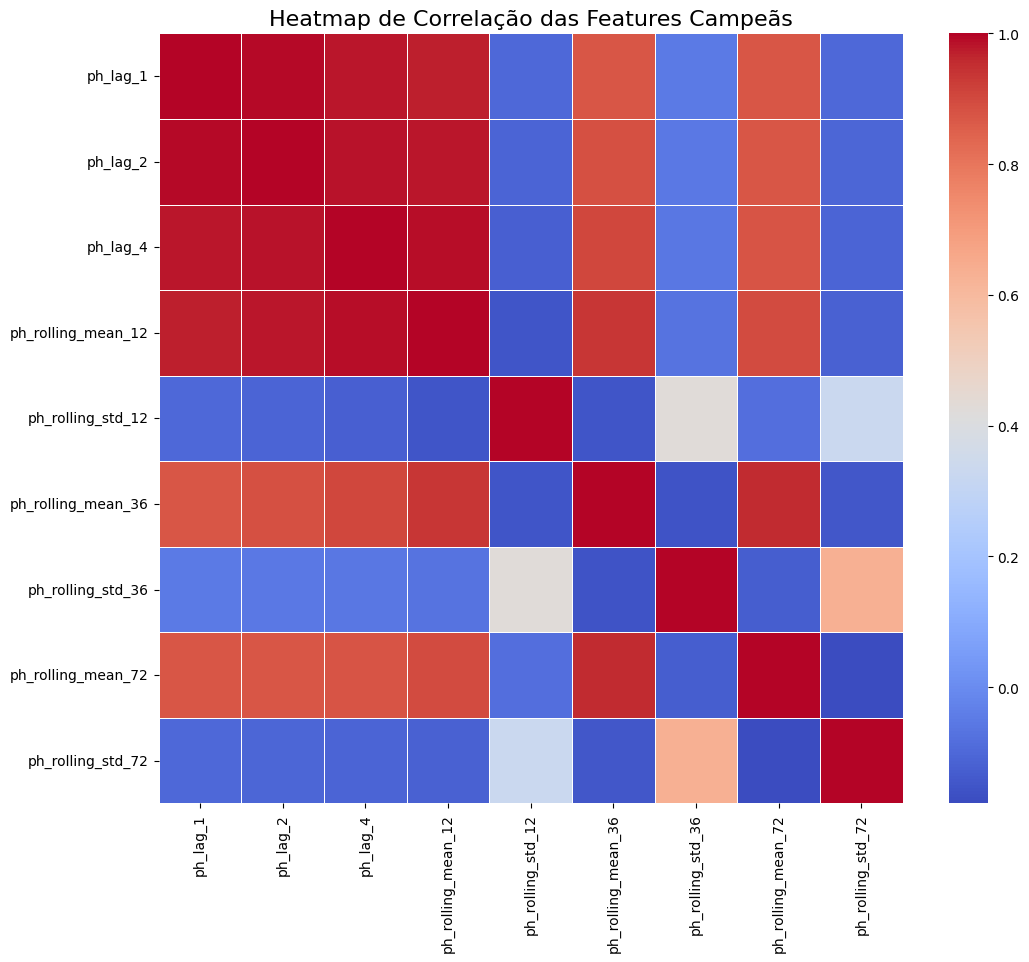


Pares de features com correlação mais alta (> 0.9):


ph_lag_1            ph_lag_2              0.993161
                    ph_lag_4              0.978768
                    ph_rolling_mean_12    0.969807
ph_lag_2            ph_lag_4              0.985875
                    ph_rolling_mean_12    0.977859
ph_lag_4            ph_rolling_mean_12    0.988965
                    ph_rolling_mean_36    0.903616
ph_rolling_mean_12  ph_rolling_mean_36    0.936641
ph_rolling_mean_36  ph_rolling_mean_72    0.956882
dtype: float64

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features (Versão Segura) ---
def create_safe_features(df, target_variable='ph', lags_list=[1,2,4], window_sizes_list=[12,36,72]):
    df_features = df.copy()
    features_list = []
    
    # Lags
    for lag in lags_list:
        feature_lag = df_features[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
        
    # Janelas Deslizantes com .shift(1)
    for window in window_sizes_list:
        feature_mean = df_features[target_variable].rolling(window=window).mean().shift(1)
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        
        feature_std = df_features[target_variable].rolling(window=window).std().shift(1)
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)

    final_df = pd.concat(features_list, axis=1)
    return final_df.dropna()

print("Criando o DataFrame com as features parcimoniosas...")
features_df = create_safe_features(df)

# --- 3. Cálculo e Visualização da Matriz de Correlação ---
print("Calculando a matriz de correlação...")
correlation_matrix = features_df.corr()

# Configuração do gráfico
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=False, # Não mostrar os números, apenas as cores
    cmap='coolwarm', # Esquema de cores: azul para negativo, vermelho para positivo
    linewidths=.5
)

plt.title('Heatmap de Correlação das Features Campeãs', fontsize=16)
plt.show()

# Opcional: Ver os pares mais correlacionados numericamente
print("\nPares de features com correlação mais alta (> 0.9):")
# Empilha a matriz para facilitar a filtragem
corr_pairs = correlation_matrix.unstack()
# Filtra para pares únicos e com alta correlação
high_corr_pairs = corr_pairs[abs(corr_pairs) > 0.9]
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1.0] # Remove a autocorrelação (correlação de uma feature com ela mesma)
display(high_corr_pairs.drop_duplicates())

# PipeLine Rapid Search Method 2

Carregando e preparando os dados...
Criando um conjunto amplo de features candidatas...
Total de features candidatas criadas: 38

--- Iniciando a Análise de Correlação ---
Features removidas por alta correlação (>0.95): 22
Número de features restantes: 16

--- Iniciando a Análise de Importância das Features com LightGBM ---
As 15 features mais importantes segundo o LightGBM:


,feature,importance
0,ph_lag_1,487
5,ph_rolling_std_6,234
4,ph_rolling_std_3,223
2,ph_lag_48,206
1,ph_lag_36,181
6,ph_rolling_std_12,177
8,ph_rolling_std_24,172
10,ph_rolling_std_72,168
13,ta_lag1,162
12,orp_lag1,156


C:\Users\User\AppData\Local\Temp\ipykernel_14284\1520564227.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='plasma')


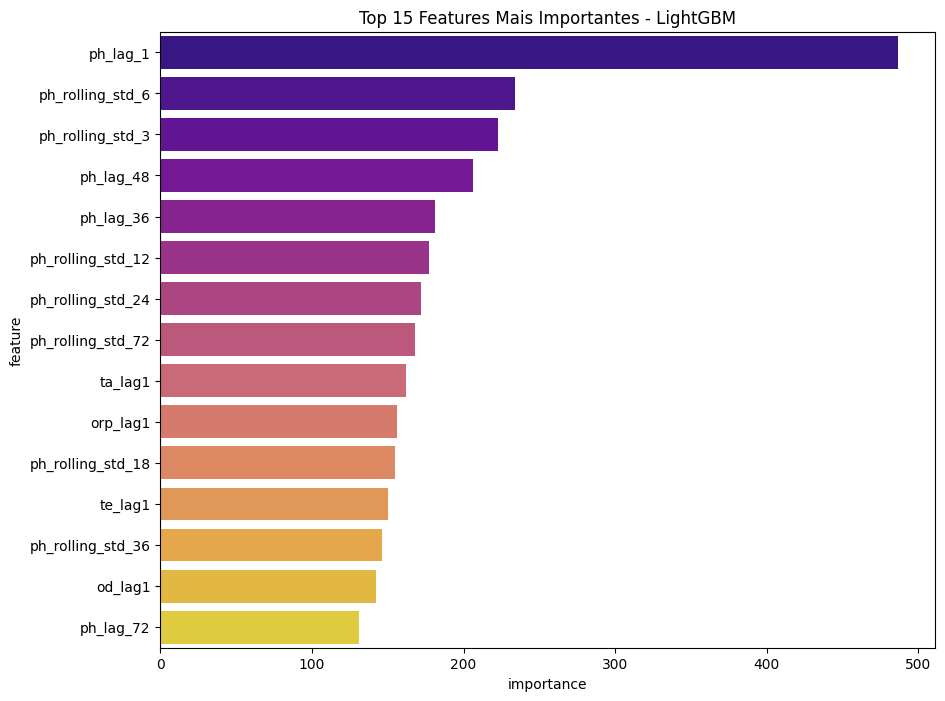


--- Iniciando a Seleção Recursiva de Features (RFECV)... Isso pode demorar. ---

Número ideal de features encontrado pelo RFECV: 6
As features selecionadas foram:
['ph_lag_1', 'ph_rolling_std_3', 'ph_rolling_std_6', 'ph_rolling_std_12', 'ph_rolling_std_18', 'ph_rolling_std_36']


In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função para Criar um CONJUNTO AMPLO de Features Candidatas ---
def create_candidate_features(df, target_variable='ph'):
    df_features = df.copy()
    features_list = []
    
    # Lags (um conjunto bem amplo)
    lags_list = list(range(1, 13)) + [18, 24, 36, 48, 72, 73, 74]
    for lag in lags_list:
        feature_lag = df_features[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
        
    # Janelas Deslizantes (um conjunto bem amplo)
    window_sizes_list = [3, 6, 12, 18, 24, 36, 72]
    for window in window_sizes_list:
        feature_mean = df_features[target_variable].rolling(window=window).mean().shift(1)
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        
        feature_std = df_features[target_variable].rolling(window=window).std().shift(1)
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)
    
    # Adicionar variáveis exógenas defasadas
    exog_vars = ['od', 'orp', 'ta', 'te', 'radiacao']
    for var in exog_vars:
        feature_exog = df_features[var].shift(1)
        feature_exog.name = f'{var}_lag1'
        features_list.append(feature_exog)

    final_df = pd.concat([df_features[[target_variable]]] + features_list, axis=1)
    return final_df.dropna()

print("Criando um conjunto amplo de features candidatas...")
df_featured = create_candidate_features(df, target_variable='ph')

# --- 3. Divisão Treino-Teste ---
TARGET = 'ph'
FEATURES = [col for col in df_featured.columns if col != TARGET]
X = df_featured[FEATURES]
y = df_featured[TARGET]

train_size = int(len(X) * 0.8) # Usar 80% para treino/validação
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
print(f"Total de features candidatas criadas: {len(FEATURES)}")

# ==============================================================================
# TÉCNICA 1: ANÁLISE DE CORRELAÇÃO (Remover Redundância)
# ==============================================================================
print("\n--- Iniciando a Análise de Correlação ---")
corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

X_train_uncorr = X_train.drop(columns=to_drop)
X_test_uncorr = X_test.drop(columns=to_drop)

print(f"Features removidas por alta correlação (>0.95): {len(to_drop)}")
print(f"Número de features restantes: {len(X_train_uncorr.columns)}")

# ==============================================================================
# TÉCNICA 2: ANÁLISE DE IMPORTÂNCIA DAS FEATURES (Ranking Rápido)
# ==============================================================================
print("\n--- Iniciando a Análise de Importância das Features com LightGBM ---")
lgbm = lgb.LGBMRegressor(objective='mae', n_jobs=-1, seed=42, verbose=-1)
lgbm.fit(X_train_uncorr, y_train)

feature_importance_df = pd.DataFrame({
    'feature': X_train_uncorr.columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print("As 15 features mais importantes segundo o LightGBM:")
display(feature_importance_df.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='plasma')
plt.title('Top 15 Features Mais Importantes - LightGBM')
plt.show()

# ==============================================================================
# TÉCNICA 3: SELEÇÃO RECURSIVA DE FEATURES (RFE) (A Mais Robusta)
# ==============================================================================
print("\n--- Iniciando a Seleção Recursiva de Features (RFECV)... Isso pode demorar. ---")
# Usamos um modelo linear simples e rápido dentro do RFE para eficiência
estimator = LinearRegression() 
# Usamos validação cruzada para séries temporais para encontrar o número ideal de features
cv = TimeSeriesSplit(n_splits=5)
# min_features_to_select=5 -> Forçamos que ele selecione pelo menos 5 features
selector = RFECV(estimator, step=1, cv=cv, scoring='neg_mean_absolute_error', min_features_to_select=5, n_jobs=-1)

selector = selector.fit(X_train_uncorr, y_train)

print(f"\nNúmero ideal de features encontrado pelo RFECV: {selector.n_features_}")
print("As features selecionadas foram:")
selected_features = X_train_uncorr.columns[selector.support_]
print(list(selected_features))

In [20]:
X_test.columns

Index(['ph_lag_1', 'ph_lag_2', 'ph_lag_4', 'ph_rolling_mean_12',
       'ph_rolling_std_12', 'ph_rolling_mean_36', 'ph_rolling_std_36',
       'ph_rolling_mean_72', 'ph_rolling_std_72'],
      dtype='object')

# FINDING A NEW CHANPION MODEL

In [21]:
# --- Bibliotecas ---
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time

print("Bibliotecas importadas com sucesso.")

# --- 1. Carregamento dos Dados ---
print("Carregando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)
print("DataFrame carregado com sucesso.")

# --- 2. Função de Engenharia de Features PARCIMONIOSA (Descorrelacionada) ---
def create_parsimonious_features(df, target_variable='ph'):
    """
    Cria um conjunto de features enxuto, removendo as features altamente correlacionadas.
    """
    df_copy = df.copy()
    features_list = []
    
    # Lags (Conjunto reduzido e focado)
    lags_list = [1, 2, 3, 4, 35, 36, 37, 71, 72, 73] # Mantemos o núcleo da nossa melhor combinação
    for lag in lags_list:
        feature_lag = df_copy[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
        
    # Janelas Deslizantes (Conjunto reduzido e focado)
    window_sizes_list = [6, 12, 36, 72] # Mantemos a nossa melhor combinação
    for window in window_sizes_list:
        feature_mean = df_copy[target_variable].rolling(window=window).mean().shift(1)
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        
        feature_std = df_copy[target_variable].rolling(window=window).std().shift(1)
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)

    # Juntar apenas as features criadas com o alvo
    final_df = pd.concat([df_copy[[target_variable]]] + features_list, axis=1)
    return final_df.dropna()

print("Função de features parcimoniosa definida.")
df_featured = create_parsimonious_features(df, target_variable='ph')
print(f"Número de features no modelo parcimonioso: {len(df_featured.columns) - 1}")

# --- 3. Preparação dos Dados de Treino e Teste ---
FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

test_size = 7 * 24 * 3 
X_train, y_train = X[:-test_size], y[:-test_size]
X_test, y_test = X[-test_size:], y[-test_size:]
print(f"Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")

# --- 4. Treinamento do Modelo RandomForest ---
print("\nIniciando o treinamento do RandomForest com features parcimoniosas...")
start_time = time.time()
rf_parsimonious_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_parsimonious_model.fit(X_train, y_train)
end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- 5. Previsão e Avaliação ---
rf_forecast = rf_parsimonious_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, rf_forecast)
print("\n--- Resultados do Modelo Parcimonioso ---")
print(f"MAE (RandomForest Parcimonioso): {mae_rf:.4f}")

Bibliotecas importadas com sucesso.
Carregando os dados...
DataFrame carregado com sucesso.
Função de features parcimoniosa definida.
Número de features no modelo parcimonioso: 18
Dados divididos: 4535 para treino, 504 para teste.

Iniciando o treinamento do RandomForest com features parcimoniosas...
Treinamento concluído em 1.30 segundos.

--- Resultados do Modelo Parcimonioso ---
MAE (RandomForest Parcimonioso): 0.0500


In [22]:
df_featured.columns

Index(['ph', 'ph_lag_1', 'ph_lag_2', 'ph_lag_3', 'ph_lag_4', 'ph_lag_35',
       'ph_lag_36', 'ph_lag_37', 'ph_lag_71', 'ph_lag_72', 'ph_lag_73',
       'ph_rolling_mean_6', 'ph_rolling_std_6', 'ph_rolling_mean_12',
       'ph_rolling_std_12', 'ph_rolling_mean_36', 'ph_rolling_std_36',
       'ph_rolling_mean_72', 'ph_rolling_std_72'],
      dtype='object')

In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time

print("--- RECOMEÇO DA FASE DE MACHINE LEARNING ---")

# --- 1. Carregamento dos Dados ---
print("\nCarregando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)
print("DataFrame carregado com sucesso.")

# --- 2. Função de Engenharia de Features PARCIMONIOSA (Segura) ---
def create_parsimonious_features(df, target_variable='ph'):
    df_copy = df.copy()
    features_list = []
    
    # Usando o conjunto de features enxuto que definimos
    lags_list = [1, 2, 4]
    window_sizes_list = [12, 36, 72]
    
    for lag in lags_list:
        feature_lag = df_copy[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
        
    for window in window_sizes_list:
        feature_mean = df_copy[target_variable].rolling(window=window).mean().shift(1)
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        
        feature_std = df_copy[target_variable].rolling(window=window).std().shift(1)
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)

    final_df = pd.concat([df_copy[[target_variable]]] + features_list, axis=1)
    return final_df.dropna()

print("Função de features parcimoniosa e segura definida.")
df_featured = create_parsimonious_features(df, target_variable='ph')
print(f"Número de features no modelo parcimonioso: {len(df_featured.columns) - 1}")

# --- 3. Preparação dos Dados de Treino e Teste ---
FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

test_size = 7 * 24 * 3 
X_train, y_train = X[:-test_size], y[:-test_size]
X_test, y_test = X[-test_size:], y[-test_size:]
print(f"Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")

# --- 4. Treinamento do LightGBM ---
print("\nIniciando o treinamento do LightGBM com features parcimoniosas...")
start_time = time.time()

lgbm_model = lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42)
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- 5. Previsão e Avaliação ---
lgbm_forecast = lgbm_model.predict(X_test)
mae_lgbm = mean_absolute_error(y_test, lgbm_forecast)
print("\n--- Resultados (Honestos) do Modelo Parcimonioso ---")
print(f"MAE (LightGBM Parcimonioso): {mae_lgbm:.4f}")

--- RECOMEÇO DA FASE DE MACHINE LEARNING ---

Carregando os dados...
DataFrame carregado com sucesso.
Função de features parcimoniosa e segura definida.
Número de features no modelo parcimonioso: 9
Dados divididos: 4536 para treino, 504 para teste.

Iniciando o treinamento do LightGBM com features parcimoniosas...
Treinamento concluído em 0.23 segundos.

--- Resultados (Honestos) do Modelo Parcimonioso ---
MAE (LightGBM Parcimonioso): 0.0501


# NIXLA mlForecast

In [30]:
import pandas as pd

# --- Carregamento e Preparação dos Dados ---
print("Carregando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- A Transformação Crucial ---
# 1. Pegar o índice 'date' e transformá-lo numa coluna normal.
# 2. Renomear a coluna de data para 'ds' e a coluna alvo para 'y'.
# 3. Adicionar a coluna 'unique_id', que é obrigatória.
df_mlf = df.reset_index().rename(columns={'index': 'ds', 'ph': 'y'})
df_mlf['unique_id'] = 'ph_sensor'

# --- Divisão Treino-Teste ---
test_size = 7 * 24 * 3 
train_df = df_mlf[:-test_size]
# Vamos guardar o dataframe completo para usar na previsão mais tarde
full_df = df_mlf

# --- A VERIFICAÇÃO ---
# Vamos verificar se a preparação funcionou antes de prosseguir.
print("\n--- Verificação das Colunas do DataFrame de Treino ---")
print("As colunas do 'train_df' são:")
print(train_df.columns)

if 'ds' in train_df.columns and 'y' in train_df.columns and 'unique_id' in train_df.columns:
    print("\nSUCESSO! O DataFrame está no formato correto. Podemos prosseguir para o treino.")
else:
    print("\nATENÇÃO! A formatação falhou. As colunas 'ds', 'y' ou 'unique_id' não foram encontradas.")

Carregando os dados...

--- Verificação das Colunas do DataFrame de Treino ---
As colunas do 'train_df' são:
Index(['ds', 'y', 'od', 'ta', 'te', 'um', 'orp', 'ec', 'tds', 'hora',
       'radiacao', 'chuva', 'vel_vento', 'dir_vento', 'umid_ins',
       'pressao_ins', 'pto_orval_ins', 'temp_ins', 'hora_seno', 'hora_cosseno',
       'unique_id'],
      dtype='object')

SUCESSO! O DataFrame está no formato correto. Podemos prosseguir para o treino.


In [28]:
df.columns

Index(['ph', 'od', 'ta', 'te', 'um', 'orp', 'ec', 'tds', 'hora', 'radiacao',
       'chuva', 'vel_vento', 'dir_vento', 'umid_ins', 'pressao_ins',
       'pto_orval_ins', 'temp_ins', 'hora_seno', 'hora_cosseno'],
      dtype='object')


Definindo o pipeline com mlforecast...

Iniciando o treinamento com mlforecast...
Treinamento concluído em 2.19 segundos.

Iniciando a previsão...

--- Resultados (mlforecast) ---
MAE (RandomForest com mlforecast): 0.4796
MAE (LightGBM com mlforecast): 0.8170


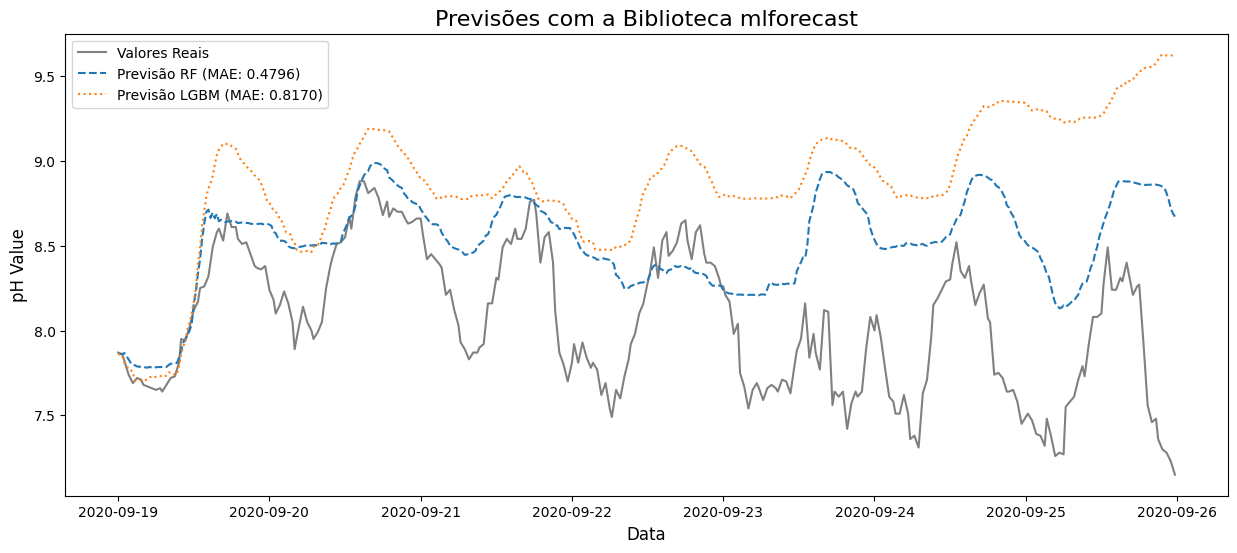

In [32]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import time

# Importar as ferramentas da mlforecast
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, RollingStd

# --- Assumimos que 'train_df' e 'full_df' já existem ---

# --- Definição do Pipeline mlforecast ---
print("\nDefinindo o pipeline com mlforecast...")
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42,
                                  learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0)
}
fcst = MLForecast(
    models=models,
    freq='20min',
    lags=[1, 2, 4],
    lag_transforms={
        1: [
            RollingMean(window_size=12), RollingMean(window_size=36), RollingMean(window_size=72),
            RollingStd(window_size=12), RollingStd(window_size=36), RollingStd(window_size=72)
        ]
    }
)

# --- Treinamento ---
print("\nIniciando o treinamento com mlforecast...")
start_time = time.time()
fcst.fit(train_df, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- Previsão ---
print("\nIniciando a previsão...")
test_size = 7 * 24 * 3
future_exog_df = full_df.tail(test_size)

# #############################################################################
# CORREÇÃO APLICADA AQUI: Trocamos 'dynamic_df' por 'X_df'
# #############################################################################
predictions = fcst.predict(h=test_size, X_df=future_exog_df)

# Juntar as previsões com os dados de teste para avaliação
results_df = full_df.tail(test_size).merge(predictions, on=['unique_id', 'ds'], how='left')

# --- Avaliação ---
print("\n--- Resultados (mlforecast) ---")
mae_rf = mean_absolute_error(results_df['y'], results_df['RandomForest'])
print(f"MAE (RandomForest com mlforecast): {mae_rf:.4f}")
mae_lgbm = mean_absolute_error(results_df['y'], results_df['LightGBM'])
print(f"MAE (LightGBM com mlforecast): {mae_lgbm:.4f}")

# --- Visualização ---
plt.figure(figsize=(15, 6))
plt.plot(results_df['ds'], results_df['y'], label='Valores Reais', color='gray')
plt.plot(results_df['ds'], results_df['RandomForest'], label=f'Previsão RF (MAE: {mae_rf:.4f})', linestyle='--')
plt.plot(results_df['ds'], results_df['LightGBM'], label=f'Previsão LGBM (MAE: {mae_lgbm:.4f})', linestyle=':')
plt.title('Previsões com a Biblioteca mlforecast', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('pH Value', fontsize=12)
plt.legend()
plt.show()

In [34]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import time

# Importar as ferramentas da mlforecast
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, RollingStd

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

df_mlf = df.reset_index().rename(columns={'index': 'ds', 'ph': 'y'})
df_mlf['unique_id'] = 'ph_sensor' 

# --- 2. Usar a mlforecast APENAS para criar as features ---
print("\nUsando mlforecast como uma 'Fábrica de Features'...")

# Instanciamos os modelos que queremos (poderia ser qualquer um, mas precisamos de um)
models = {'placeholder': lgb.LGBMRegressor()}

# Definimos as features que queremos
fcst = MLForecast(
    models=models,
    freq='20min',
    lags=[1, 2, 4], # Nossos lags parcimoniosos
    lag_transforms={
        1: [ # O .shift(1) é automático
            RollingMean(window_size=12), RollingMean(window_size=36), RollingMean(window_size=72),
            RollingStd(window_size=12), RollingStd(window_size=36), RollingStd(window_size=72)
        ]
    }
)

# O método .preprocess() cria o DataFrame com as features e o alvo
# return_X_y=False garante que ele retorna um único DataFrame
df_featured = fcst.preprocess(df_mlf, id_col='unique_id', time_col='ds', target_col='y', static_features=[], return_X_y=False)
df_featured = df_featured.dropna()
print("DataFrame com features criado com sucesso pela mlforecast.")

# --- 3. Divisão Treino-Teste (A nossa abordagem manual) ---
TARGET = 'y'
FEATURES = [col for col in df_featured.columns if col not in ['unique_id', 'ds', 'y']]
X = df_featured[FEATURES]
y = df_featured[TARGET]

test_size = 7 * 24 * 3 
X_train, y_train = X[:-test_size], y[:-test_size]
X_test, y_test = X[-test_size:], y[-test_size:]
print(f"Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")

# --- 4. Treino e Avaliação Single-Step ---
print("\n--- Iniciando a Avaliação Single-Step ('Sprint') ---")
models_to_test = {
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42)
}

results_sprint = {}

for name, model in models_to_test.items():
    print(f"Treinando {name}...")
    if name == 'LightGBM':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(100, verbose=False)])
    else:
        model.fit(X_train, y_train)
    
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    results_sprint[name] = mae
    print(f"  -> MAE (Single-Step): {mae:.4f}")

# --- 5. Comparação Final ---
print("\n--- Comparativo Final de Performance ---")
print(f"MAE (RandomForest - Single-Step): {results_sprint['RandomForest']:.4f}")
print(f"MAE (LightGBM - Single-Step):     {results_sprint['LightGBM']:.4f}")
print("\n--- Resultados da 'Maratona' (Multi-Step Recursivo) da última execução ---")
print(f"MAE (RandomForest - Multi-Step): 0.4796")
print(f"MAE (LightGBM - Multi-Step):     0.8170")

Carregando e preparando os dados...

Usando mlforecast como uma 'Fábrica de Features'...
DataFrame com features criado com sucesso pela mlforecast.
Dados divididos: 4536 para treino, 504 para teste.

--- Iniciando a Avaliação Single-Step ('Sprint') ---
Treinando RandomForest...
  -> MAE (Single-Step): 0.0681
Treinando LightGBM...
  -> MAE (Single-Step): 0.0571

--- Comparativo Final de Performance ---
MAE (RandomForest - Single-Step): 0.0681
MAE (LightGBM - Single-Step):     0.0571

--- Resultados da 'Maratona' (Multi-Step Recursivo) da última execução ---
MAE (RandomForest - Multi-Step): 0.4796
MAE (LightGBM - Multi-Step):     0.8170


Carregando e preparando os dados...
Função de features segura definida.
Criando as 504 colunas alvo para a previsão direta...
Dados de treino preparados com 4535 amostras.

Iniciando o treino dos 504 modelos 'especialistas' do XGBoost... Isso vai demorar.


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [22:09<00:00,  2.64s/it]


Treino e previsão concluídos em 22.17 minutos.

--- Resultado da Avaliação Justa e Correta (Direta) ---
MAE Final do XGBoost (Maratona Direta de 7 dias): 0.1443
MAE Final do ARIMAX (Maratona Recursiva de 7 dias): 0.3347


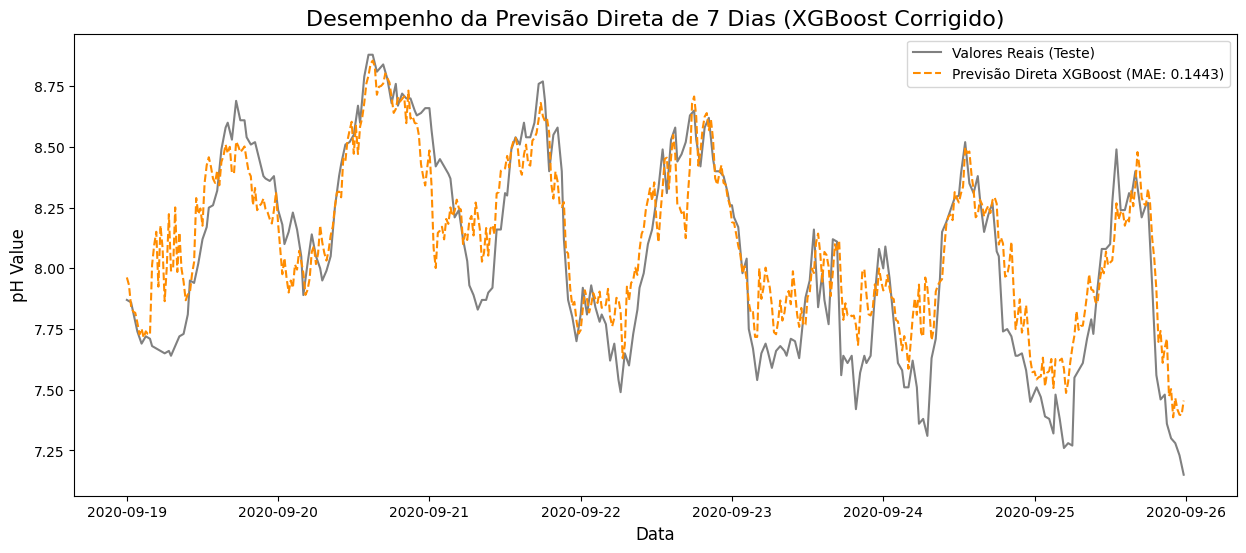

In [35]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm # Para a barra de progresso
import time
import matplotlib.pyplot as plt

# --- 1. Carregamento dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features (VERSÃO SEGURA E CORRETA) ---
def create_safe_features(df, target_variable='ph'):
    df_features = df.copy()
    features_list = []
    
    # Usando o conjunto de features parcimonioso que definimos
    lags_list = [1, 2, 4]
    window_sizes_list = [12, 36, 72]
    
    for lag in lags_list:
        feature_lag = df_features[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
        
    for window in window_sizes_list:
        feature_mean = df_features[target_variable].rolling(window=window).mean().shift(1)
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        
        feature_std = df_features[target_variable].rolling(window=window).std().shift(1)
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)

    # Adicionar variáveis exógenas defasadas (do passado)
    exog_vars = ['od', 'orp', 'ta', 'te', 'radiacao']
    for var in exog_vars:
        feature_exog = df_features[var].shift(1)
        feature_exog.name = f'{var}_lag1'
        features_list.append(feature_exog)

    final_df = pd.concat([df_features[[target_variable]]] + features_list, axis=1)
    return final_df.dropna()

print("Função de features segura definida.")
df_featured = create_safe_features(df, target_variable='ph')

# --- 3. Criação dos Alvos Multi-Step ---
print("Criando as 504 colunas alvo para a previsão direta...")
horizon = 7 * 24 * 3  # 504 passos
target_list = []
for i in range(1, horizon + 1):
    target_series = df_featured['ph'].shift(-i)
    target_series.name = f'ph_target_t+{i}'
    target_list.append(target_series)

df_final = pd.concat([df_featured, pd.concat(target_list, axis=1)], axis=1)
df_final = df_final.dropna()

# --- 4. Divisão Treino-Teste ---
train_df = df_final[:-1]
X_test_point = df_final.iloc[-1:]

# Definimos as features que não são nem o alvo original nem os alvos futuros
original_features = [col for col in df_featured.columns if col != 'ph']
X_train = train_df[original_features]
X_test = X_test_point[original_features]
print(f"Dados de treino preparados com {len(X_train)} amostras.")

# --- 5. Pipeline de Previsão Direta com XGBoost ---
print(f"\nIniciando o treino dos {horizon} modelos 'especialistas' do XGBoost... Isso vai demorar.")
start_time = time.time()
predictions_direct_xgb = []

for i in tqdm(range(1, horizon + 1)):
    target_col = f'ph_target_t+{i}'
    y_train_step = train_df[target_col]
    
    # Usamos os hiperparâmetros otimizados para o XGBoost
    xgb_specialist = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, n_jobs=-1, seed=42,
        learning_rate=0.05, max_depth=7, subsample=1.0, colsample_bytree=1.0,
        early_stopping_rounds=100
    )
    # O XGBoost precisa de um eval_set para o early stopping, podemos usar uma pequena parte final do treino
    eval_set = [(X_train.tail(500), y_train_step.tail(500))]
    xgb_specialist.fit(X_train, y_train_step, eval_set=eval_set, verbose=False)
    
    prediction = xgb_specialist.predict(X_test)[0]
    predictions_direct_xgb.append(prediction)

end_time = time.time()
print(f"Treino e previsão concluídos em {(end_time - start_time)/60:.2f} minutos.")

# --- 6. Avaliação Final e Justa ---
true_values_test = df['ph'][-horizon:].values
mae_xgb_direct = mean_absolute_error(true_values_test, predictions_direct_xgb)

print(f"\n--- Resultado da Avaliação Justa e Correta (Direta) ---")
print(f"MAE Final do XGBoost (Maratona Direta de 7 dias): {mae_xgb_direct:.4f}")
print(f"MAE Final do ARIMAX (Maratona Recursiva de 7 dias): 0.3347")

# --- 7. Visualização ---
plt.figure(figsize=(15, 6))
plt.plot(df.index[-horizon:], true_values_test, label='Valores Reais (Teste)', color='gray')
plt.plot(df.index[-horizon:], predictions_direct_xgb, label=f'Previsão Direta XGBoost (MAE: {mae_xgb_direct:.4f})', color='darkorange', linestyle='--')
plt.title('Desempenho da Previsão Direta de 7 Dias (XGBoost Corrigido)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('pH Value', fontsize=12)
plt.legend()
plt.show()

Carregando e preparando os dados...
Função de features segura definida.
Criando as 504 colunas alvo para a previsão direta...
Dados de treino preparados com 4535 amostras.

Iniciando o treino dos 504 especialistas para cada modelo...

--- Treinando para o modelo: RandomForest ---


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [11:51<00:00,  1.41s/it]


Treino e previsão para RandomForest concluídos em 11.86 minutos.

--- Treinando para o modelo: LightGBM ---


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [00:44<00:00, 11.44it/s]


Treino e previsão para LightGBM concluídos em 0.73 minutos.

Processo completo concluído em 12.60 minutos.

--- Resultado da Avaliação Justa (Direta) ---
MAE Final do RandomForest (Maratona Direta): 0.1657
MAE Final do LightGBM (Maratona Direta): 0.2446
MAE Final do ARIMAX (Maratona Recursiva): 0.3347


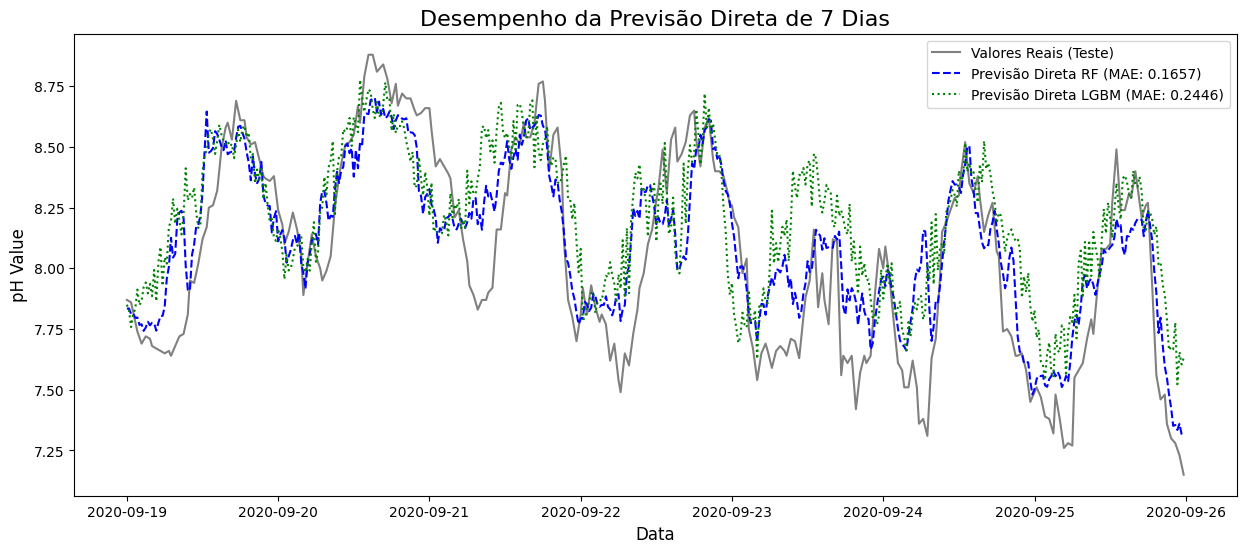

In [36]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features (VERSÃO SEGURA E CORRETA) ---
def create_safe_features(df, target_variable='ph'):
    df_copy = df.copy()
    features_list = []
    
    # Usando o conjunto de features parcimonioso que definimos
    lags_list = [1, 2, 4]
    window_sizes_list = [12, 36, 72]
    
    for lag in lags_list:
        feature_lag = df_copy[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
        
    for window in window_sizes_list:
        feature_mean = df_copy[target_variable].rolling(window=window).mean().shift(1)
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        
        feature_std = df_copy[target_variable].rolling(window=window).std().shift(1)
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)

    exog_vars = ['od', 'orp', 'ta', 'te', 'radiacao']
    for var in exog_vars:
        feature_exog = df_copy[var].shift(1)
        feature_exog.name = f'{var}_lag1'
        features_list.append(feature_exog)

    final_df = pd.concat([df_copy[[target_variable]]] + features_list, axis=1)
    return final_df.dropna()

print("Função de features segura definida.")
df_featured = create_safe_features(df, target_variable='ph')

# --- 3. Criação dos Alvos Multi-Step ---
print("Criando as 504 colunas alvo para a previsão direta...")
horizon = 7 * 24 * 3
target_list = []
for i in range(1, horizon + 1):
    target_series = df_featured['ph'].shift(-i)
    target_series.name = f'ph_target_t+{i}'
    target_list.append(target_series)

df_final = pd.concat([df_featured, pd.concat(target_list, axis=1)], axis=1)
df_final = df_final.dropna()

# --- 4. Divisão Treino-Teste ---
train_df = df_final[:-1]
X_test_point = df_final.iloc[-1:]
original_features = [col for col in df_featured.columns if col != 'ph']
X_train = train_df[original_features]
X_test = X_test_point[original_features]
print(f"Dados de treino preparados com {len(X_train)} amostras.")

# --- 5. Pipeline de Previsão Direta para Múltiplos Modelos ---
models_to_run = {
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=100, n_jobs=-1, verbose=-1, seed=42,
                                  learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0)
}

all_predictions = {}
print(f"\nIniciando o treino dos {horizon} especialistas para cada modelo...")
start_total_time = time.time()

for model_name, model_instance in models_to_run.items():
    print(f"\n--- Treinando para o modelo: {model_name} ---")
    start_model_time = time.time()
    predictions_direct = []
    
    for i in tqdm(range(1, horizon + 1)):
        target_col = f'ph_target_t+{i}'
        y_train_step = train_df[target_col]
        
        model_instance.fit(X_train, y_train_step)
        
        prediction = model_instance.predict(X_test)[0]
        predictions_direct.append(prediction)
    
    all_predictions[model_name] = predictions_direct
    end_model_time = time.time()
    print(f"Treino e previsão para {model_name} concluídos em {(end_model_time - start_model_time)/60:.2f} minutos.")

end_total_time = time.time()
print(f"\nProcesso completo concluído em {(end_total_time - start_total_time)/60:.2f} minutos.")

# --- 6. Avaliação Final e Justa ---
true_values_test = df['ph'][-horizon:].values
print(f"\n--- Resultado da Avaliação Justa (Direta) ---")

mae_rf_direct = mean_absolute_error(true_values_test, all_predictions['RandomForest'])
print(f"MAE Final do RandomForest (Maratona Direta): {mae_rf_direct:.4f}")

mae_lgbm_direct = mean_absolute_error(true_values_test, all_predictions['LightGBM'])
print(f"MAE Final do LightGBM (Maratona Direta): {mae_lgbm_direct:.4f}")

print(f"MAE Final do ARIMAX (Maratona Recursiva): 0.3347")

# --- 7. Visualização ---
plt.figure(figsize=(15, 6))
plt.plot(df.index[-horizon:], true_values_test, label='Valores Reais (Teste)', color='gray')
plt.plot(df.index[-horizon:], all_predictions['RandomForest'], label=f'Previsão Direta RF (MAE: {mae_rf_direct:.4f})', color='blue', linestyle='--')
plt.plot(df.index[-horizon:], all_predictions['LightGBM'], label=f'Previsão Direta LGBM (MAE: {mae_lgbm_direct:.4f})', color='green', linestyle=':')
plt.title('Desempenho da Previsão Direta de 7 Dias', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('pH Value', fontsize=12)
plt.legend()
plt.show()

In [38]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import time
from IPython.display import display

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features PARCIMONIOSA (Segura) ---
def create_parsimonious_features(df, target_variable='ph'):
    df_copy = df.copy()
    features_list = []
    lags_list = [1, 2, 4]
    window_sizes_list = [12, 36, 72]
    for lag in lags_list:
        feature_lag = df_copy[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
    for window in window_sizes_list:
        feature_mean = df_copy[target_variable].rolling(window=window).mean().shift(1)
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        feature_std = df_copy[target_variable].rolling(window=window).std().shift(1)
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)
    exog_vars = ['od', 'orp', 'ta', 'te', 'radiacao']
    for var in exog_vars:
        feature_exog = df_copy[var].shift(1)
        feature_exog.name = f'{var}_lag1'
        features_list.append(feature_exog)
    final_df = pd.concat([df_copy[[target_variable]]] + features_list, axis=1)
    return final_df.dropna()

df_featured = create_parsimonious_features(df, target_variable='ph')

# --- 3. Preparação dos Dados de Treino e Teste ---
FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]
test_size = 7 * 24 * 3 
X_train, y_train = X[:-test_size], y[:-test_size]
X_test, y_test = X[-test_size:], y[-test_size:]

# --- 4. Definir e Treinar Todos os Modelos ---
models_to_run = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Decision Tree (Otimizado)': DecisionTreeRegressor(criterion='squared_error', max_depth=20, min_samples_leaf=1, min_samples_split=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'LightGBM (Otimizado)': lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42,
                                             learning_rate=0.1, max_depth=-1, num_leaves=20, reg_alpha=0.5, reg_lambda=0),
    'XGBoost (Otimizado)': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, n_jobs=-1, seed=42,
                                            learning_rate=0.05, max_depth=7, subsample=1.0, colsample_bytree=1.0)
}

results_list = []
print("\n--- Iniciando a Avaliação Final Single-Step ('Sprint') ---")

for model_name, model in models_to_run.items():
    print(f"Treinando {model_name}...")
    start_time = time.time()
    if model_name == 'LightGBM (Otimizado)':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[lgb.early_stopping(100, verbose=False)])
    elif model_name == 'XGBoost (Otimizado)':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)
        
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    
    results_list.append({
        'Modelo': model_name,
        'MAE (Single-Step)': mae
    })
    
# Adicionar os benchmarks estatísticos para uma visão completa
results_list.append({'Modelo': 'Seasonal Naive', 'MAE (Single-Step)': 0.3019})
results_list.append({'Modelo': 'ARIMAX (Multi-Step)', 'MAE (Single-Step)': 0.3347}) # Nota: O MAE do ARIMAX é multi-step

# --- 5. Resultados Finais ---
final_results_df = pd.DataFrame(results_list).sort_values(by='MAE (Single-Step)', ascending=True).reset_index(drop=True)
print("\n--- Tabela Comparativa Final (Previsão Single-Step) ---")
display(final_results_df)

Carregando e preparando os dados...

--- Iniciando a Avaliação Final Single-Step ('Sprint') ---
Treinando Linear Regression...
Treinando Decision Tree (Otimizado)...
Treinando Random Forest...
Treinando LightGBM (Otimizado)...
Treinando XGBoost (Otimizado)...

--- Tabela Comparativa Final (Previsão Single-Step) ---


,Modelo,MAE (Single-Step)
0,Linear Regression,0.046366
1,LightGBM (Otimizado),0.059752
2,Random Forest,0.061617
3,Decision Tree (Otimizado),0.075649
4,XGBoost (Otimizado),0.130030
5,Seasonal Naive,0.301900
6,ARIMAX (Multi-Step),0.334700


# Stacking MOdels

In [40]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import time
from IPython.display import display

# --- 1. Carregamento e Preparação dos Dados ---
print("Carregando e preparando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features PARCIMONIOSA (Segura) ---
def create_parsimonious_features(df, target_variable='ph'):
    df_copy = df.copy()
    features_list = []
    lags_list = [1, 2, 4]
    window_sizes_list = [12, 36, 72]
    for lag in lags_list:
        feature_lag = df_copy[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
    for window in window_sizes_list:
        feature_mean = df_copy[target_variable].rolling(window=window).mean().shift(1)
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        feature_std = df_copy[target_variable].rolling(window=window).std().shift(1)
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)
    exog_vars = ['od', 'orp', 'ta', 'te', 'radiacao']
    for var in exog_vars:
        feature_exog = df_copy[var].shift(1)
        feature_exog.name = f'{var}_lag1'
        features_list.append(feature_exog)
    final_df = pd.concat([df_copy[[target_variable]]] + features_list, axis=1)
    return final_df.dropna()

print("Função de features parcimoniosa e segura definida.")
df_featured = create_parsimonious_features(df, target_variable='ph')

# --- 3. Preparação dos Dados de Treino e Teste ---
FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]
test_size = 7 * 24 * 3 
X_train, y_train = X[:-test_size], y[:-test_size]
X_test, y_test = X[-test_size:], y[-test_size:]
print("Dados preparados e divididos.")

# --- 4. Definição do Pipeline de Stacking (Versão Correta) ---
print("\nDefinindo o pipeline de Stacking...")

# Nossos "Diretores" (modelos de Nível 0)
estimators = [
    ('RandomForest', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
    ('LightGBM', lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42)),
    ('LinearRegression', LinearRegression(n_jobs=-1)) # Adicionando diversidade
]

# O "Presidente" (Meta-Modelo de Nível 1)
meta_model = Ridge()

# Usamos KFold(shuffle=False) para ser compatível com o StackingRegressor
cv_stacking = KFold(n_splits=5, shuffle=False)

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=cv_stacking,
    n_jobs=-1,
    verbose=2
)
print("Pipeline definido.")

# --- 5. Treinamento e Avaliação ---
print("\nIniciando o treinamento do modelo de Stacking... Isso pode ser demorado.")
start_time = time.time()

stacking_model.fit(X_train, y_train)

end_time = time.time()
print(f"Treinamento do Stacking concluído em {end_time - start_time:.2f} segundos.")

stacking_forecast = stacking_model.predict(X_test)
mae_stacking = mean_absolute_error(y_test, stacking_forecast)

print("\n--- Resultado (Honesto) do Modelo de Stacking ---")
print(f"MAE Final (Stacking): {mae_stacking:.4f}")

Carregando e preparando os dados...
Função de features parcimoniosa e segura definida.
Dados preparados e divididos.

Definindo o pipeline de Stacking...
Pipeline definido.

Iniciando o treinamento do modelo de Stacking... Isso pode ser demorado.
Treinamento do Stacking concluído em 36.84 segundos.

--- Resultado (Honesto) do Modelo de Stacking ---
MAE Final (Stacking): 0.0462
